### CNN Model with features v2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation_v2
from features import get_apple_stock_with_features

In [4]:
important_cols = ['Open', 
                  'High', 
                  'Low', 
                  'Close', # <-- our target (pos=3)
                  'Close_ndx',
                  'kc_10',
                  'ema_26', 
                  'ema_12', 
#                   'macd',
#                   'macd_diff',
#                   'macd_sig',
                  'mavg_200', 
                  'mavg_50', 
                  'mavg_20', 
                  'mavg_10', 
                  'b_hband_20', 
                  'b_lband_20', 
#                   'ao', 
                  'ichimoku_a', 
                  'kc_lband_10',
                  'dc_lband_20',
                  'dc_hband_20', 
#                   'tsi', 
                  'nvi', 
                  'mi',
                  'atr_14'
                 ]
apple_stock = get_apple_stock_with_features(important_cols)

In [5]:
short_series = get_range(apple_stock, '2003-01-01')

In [6]:
# Model parameters
look_back = 5 # days window look back
n_features = len(short_series.columns.values)
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 1000 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [7]:
train, test = train_test_split(short_series,'2018-05-31')

In [8]:
from sklearn.preprocessing import PowerTransformer

In [9]:
# we need to use yeo-johnson transformation since we have negative values
pt = PowerTransformer(method='box-cox')

In [10]:
transformed_train = pt.fit_transform(train.values)
transformed_test = pt.transform(test.values)

# transformed_train = train.values
# transformed_test = test.values

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaled_train = scaler.fit_transform(transformed_train)
scaled_test = scaler.transform(transformed_test)

In [14]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)

# we're only interested in the Close price (pos=3)
y_train = y_train[:, :, 3]

In [15]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.layers import LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [16]:
def build_CNN(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=2, padding='same', input_shape=(look_back, n_features)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, kernel_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [48]:
model = build_CNN(look_back, n_features, n_outputs, optimizer=Adam(0.00001))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 5, 64)             2752      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 5, 64)             0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2, 32)             4128      
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 7,205
Trainable params: 7,205
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/1000
3871/3871 [==============================] - 1s 167us/step - loss: 0.0220
Epoch 2/1000
3871/3871 [==============================] - 0s 95us/step - loss: 0.0026
Epoch 3/1000
3871/3871 [==============================] - 0s 96us/step - loss: 0.0011
Epoch 4/1000
3871/3871 [==============================] - 0s 95us/step - loss: 0.0010
Epoch 5/1000
3871/3871 [==============================] - 0s 95us/step - loss: 9.6789e-04
Epoch 6/1000
3871/3871 [==============================] - 0s 95us/step - loss: 9.0686e-04
Epoch 7/1000
3871/3871 [==============================] - 0s 100us/step - loss: 8.5035e-04
Epoch 8/1000
3871/3871 [==============================] - 0s 95us/step - loss: 7.9920e-04
Epoch 9/1000
3871/3871 [==============================] - 0s 95us/step - loss: 7.5282e-04
Epoch 10/1000
3871/3871 [==============================] - 0s 95us/step - loss: 7.1198e-04
Epoch 11/1000
3871/3871 [==============================] - 0s 95us/step - loss: 6.7618e-04
Epoch 12/1000
3871/387

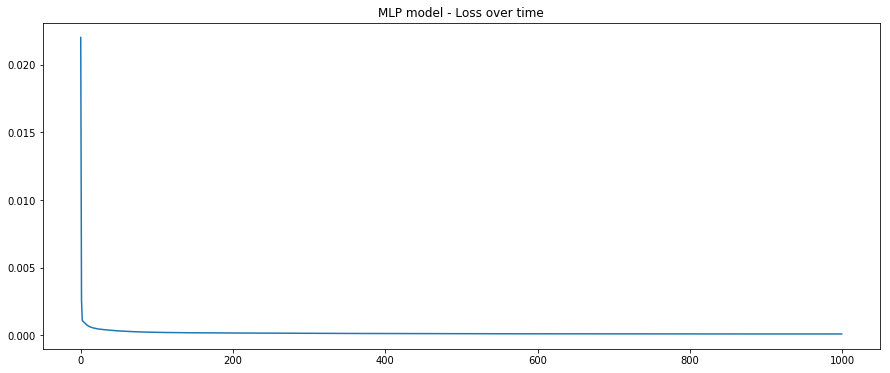

In [51]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [52]:
model.save_weights('cnn-model_weights.h5')

In [53]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation_v2(model, 
                                            scaled_train, scaled_test[:252], 
                                            size=size, 
                                            look_back=look_back, 
                                            n_features=n_features, 
                                            n_outputs=n_outputs)

In [54]:
from utils import plot_walk_forward_validation, descale_with_features
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [55]:
descaled_preds, descaled_test = descale_with_features(scaler, pt, 
                                                      predictions, 
                                                      scaled_test, 
                                                      n_features)

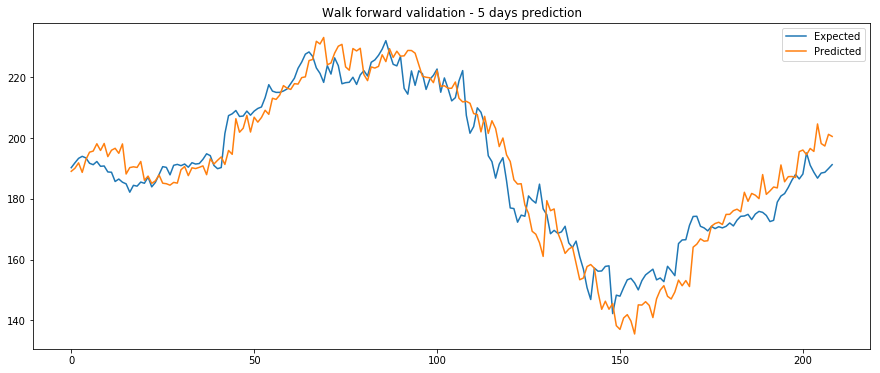

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size][:, 3])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

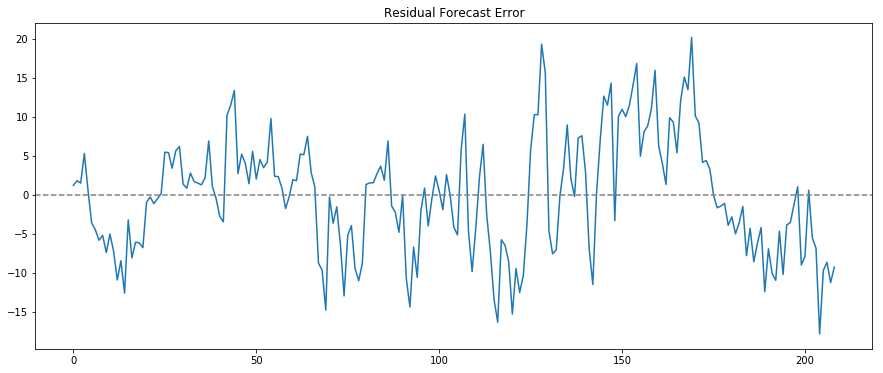

In [57]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size][:, 3])

In [58]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size][:, 3],
                          model_name='MLP with features', 
                          total_days=size, steps=n_outputs)

MLP with features[252 days, 5 days forecast]:

Forecast Bias: -0.231
MAE: 6.023
MSE: 55.938
RMSE: 7.479
MAPE: 3.294


In [58]:
model.load_weights('mlp-model_weights.h5')